In [1]:
import mmap
import os
import time
import numpy as np
import matplotlib.pyplot as plt

os.system('cat /root/trap_test.bit > /dev/xdevcfg')

axi_gpio_regset = np.dtype([
    ('gpio1_data'   , 'uint32'),
    ('gpio1_control', 'uint32'),
    ('gpio2_data'   , 'uint32'),
    ('gpio2_control', 'uint32')
])

memory_file_handle = os.open('/dev/mem', os.O_RDWR)
axi_mmap_trap = mmap.mmap(fileno=memory_file_handle, length=mmap.PAGESIZE, offset=0x41200000)
axi_numpy_array_trap = np.recarray(1, axi_gpio_regset, buf=axi_mmap_trap)
axi_array_contents_trap = axi_numpy_array_trap[0]

axi_mmap_peak = mmap.mmap(fileno=memory_file_handle, length=mmap.PAGESIZE, offset=0x41210000)
axi_numpy_array_peak = np.recarray(1, axi_gpio_regset, buf=axi_mmap_peak)
axi_array_contents_peak = axi_numpy_array_peak[0]

In [4]:
Kdelay = 10
Ldelay = 15
mult = 10 # Equal to tau of exp. decay signal

sig_amp = 1000
decay = 14825 # 2^14 * e^(-1 / tau)

threshold = 1000

# Establish constants within modules and allow modules to reset
axi_array_contents_trap.gpio1_data = (Kdelay << 16) + (Ldelay << 2)
axi_array_contents_trap.gpio2_data = (sig_amp << 18) + (mult << 2)
axi_array_contents_peak.gpio1_data = (decay << 16) + threshold
time.sleep(0.01)

# Release reset
axi_array_contents_trap.gpio1_data += 1
time.sleep(0.01)

# Trigger signal and allow filter to process signal
axi_array_contents_trap.gpio2_data += 1
time.sleep(1)

# Calculate peak
peak = axi_array_contents_peak.gpio2_data / (Kdelay * (mult + 0.5))
print(axi_array_contents_peak.gpio2_data)

print("Peak: ", peak)

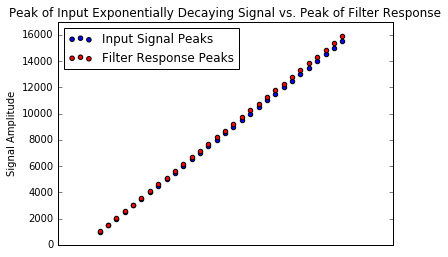

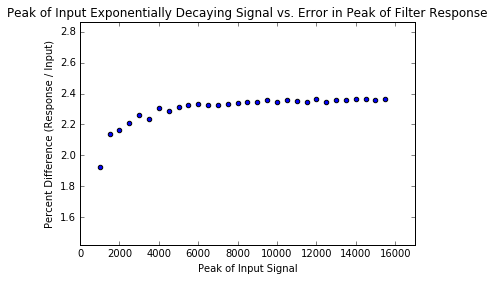

In [3]:
# Uncomment for interactive plots, very slow
# %matplotlib notebook
# %matplotlib qt

Kdelay = 10
Ldelay = 15
mult = 10 # Equal to tau of exp. decay signal

decay = 14825 # 2^14 * e^(-1 / tau)

threshold = 1000

sim_amps = np.arange(1000,16000,500)

calc_amps = np.array([])

errors = np.array([])

for amp in sim_amps:
    # Establish constants within modules and allow modules to reset
    axi_array_contents_trap.gpio1_data = (Kdelay << 16) + (Ldelay << 2)
    axi_array_contents_trap.gpio2_data = (amp << 18) + (mult << 2)
    axi_array_contents_peak.gpio1_data = (decay << 16) + threshold
    time.sleep(0.01)
    
    # Release reset
    axi_array_contents_trap.gpio1_data += 1
    time.sleep(0.01)
    
    # Trigger signal and allow filter to process signal
    axi_array_contents_trap.gpio2_data += 1
    time.sleep(0.5)
    
    # Calculate peak, add peak and error to arrays
    peak = axi_array_contents_peak.gpio2_data / (Kdelay * (mult + 0.5))
    calc_amps  = np.append(calc_amps, peak)
    errors = np.append(errors, ((peak/amp) - 1) * 100)

index = range(len(sim_amps))
    
plt.scatter(index, sim_amps, label="Input Signal Peaks")
plt.scatter(index, calc_amps, c='r', label="Filter Response Peaks")
plt.ylabel("Signal Amplitude")
plt.legend(loc="upper left")
plt.title("Peak of Input Exponentially Decaying Signal vs. Peak of Filter Response")
plt.ylim([0,17000])
plt.xticks([])
plt.show()

plt.scatter(sim_amps, errors)
plt.xlabel("Peak of Input Signal")
plt.ylabel("Percent Difference (Response / Input)")
plt.title("Peak of Input Exponentially Decaying Signal vs. Error in Peak of Filter Response")
plt.xlim([0,17000])
plt.ylim([min(errors)-0.5, max(errors)+0.5])
plt.show()

In [10]:
import sys
!{sys.executable} -m pip install numpy

^C
